**There are 2 sets of data (2D Heterostructures and 2D materials at 300K) and for each dataset a linear multiple regression model has been developed.**

In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize':20,
         'figure.figsize':(12,8),
         'axes.labelsize': 20,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16}

mpl.rcParams.update(params)
%matplotlib inline

In [20]:
data = pd.read_excel("2DH_elastic_300K.xlsx", index_col = 0)

del data["v"]
del data["Vl"]
del data["C66"]
del data["Vt"]
     
data.describe()

,K,G,Y2D,C11,C12
count,338.000000,338.000000,338.000000,338.000000,338.000000
mean,88.049763,47.048077,115.258136,135.098846,40.998964
std,61.149084,36.270821,88.725150,92.652295,39.053304
min,0.140000,0.020000,0.090000,1.330000,-112.860000
25%,30.032500,15.310000,36.235000,51.592500,12.887500
50%,82.915000,41.220000,96.405000,125.040000,40.915000
75%,140.297500,73.620000,189.522500,213.932500,70.117500
max,236.760000,159.230000,339.710000,351.070000,157.060000


**Step-2:** Choosing a model and features

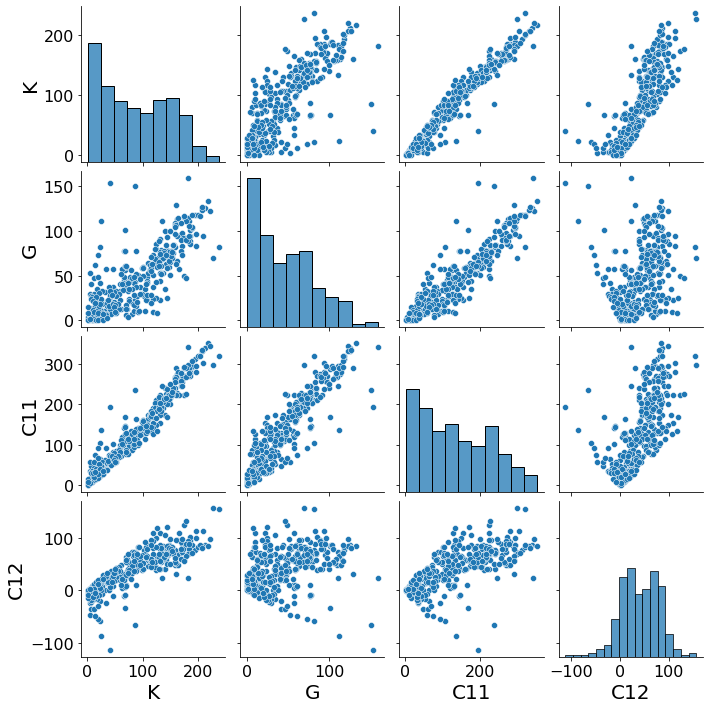

In [21]:
features = [c for c in data.columns if c != "Y2D"]
x = data[features]
y = data["Y2D"]
grid = sns.pairplot(data[features])
#grid.savefig("Images_2DH_300K/CorrMap", dpi = 1200, transparent = False, facecolor = 'white')

In [22]:
from sklearn.feature_selection import SelectKBest, f_regression
    
sel = SelectKBest(f_regression, k=4)
sel.fit_transform(x, y)
s = ', '.join(['%s: %.3e' % (i, j) for i, j in zip(x.columns, sel.pvalues_)])
print("The p values for the variables are " + s)

The p values for the variables are K: 6.821e-143, G: 9.268e-167, C11: 4.095e-240, C12: 2.264e-30


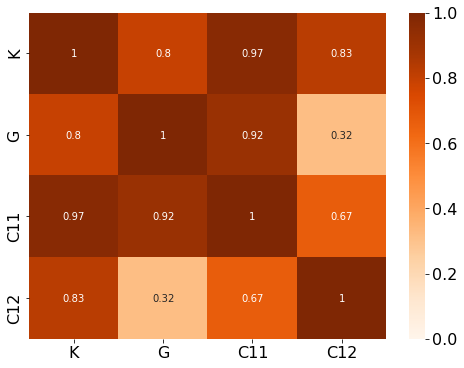

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(x.corr(), cmap="Oranges", annot = True, vmin=0, vmax=1, ax=ax);
#f.savefig("Images_2DH_300K/Heatmap", dpi = 1200, transparent = False, facecolor = 'white')

_**Step-3:** MLR with the entire dataset to check the viability of the chosen model_

The R value for this fit is 0.975748
Y2D = -10.6 + 1.74e+01 K + -5.05e+00 G + -5.14e+00 C11 + -1.16e+01 C12


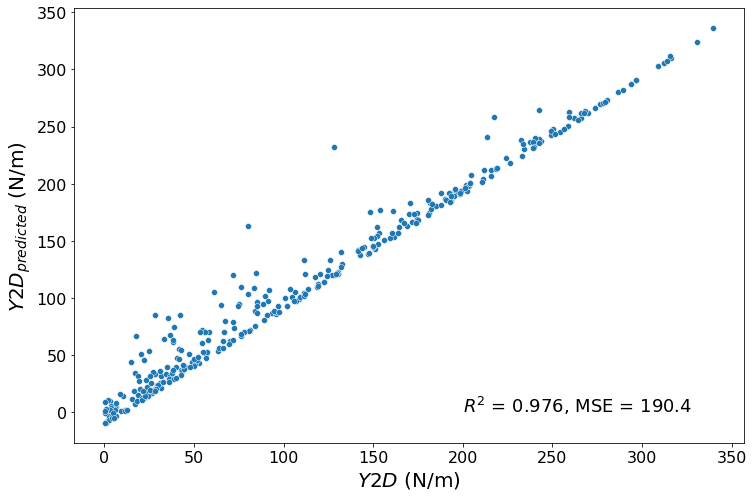

In [24]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
reg = linear_model.LinearRegression()
reg.fit(x,y)
r2 = reg.score(x,y)
print("The R value for this fit is %.6f" % (r2))

equation = ["%.2e %s" % (v, f) for v, f in zip(reg.coef_, features)]
print("Y2D = %.1f + %s" % (reg.intercept_, " + ".join(equation)))
f, ax = plt.subplots(figsize=(12, 8))
yhat = reg.predict(data[features])
sns.scatterplot(x=y, y=yhat)
plt.ylabel(r"$Y2D_{predicted}$ (N/m)")
plt.xlabel(r"$Y2D$ (N/m)")
plt.annotate(r"$R^2$ = %.3f, MSE = %.1f" % (r2, mean_squared_error(y, yhat)), (200, 0), fontsize=18);
#f.savefig("Images_2DH_300K/Fit_all", dpi = 1200, transparent = False, facecolor = 'white')

_**Step-4:** Cross validation - 5-fold cross validation is done to assess the model's performance and rule out overfitting of data._

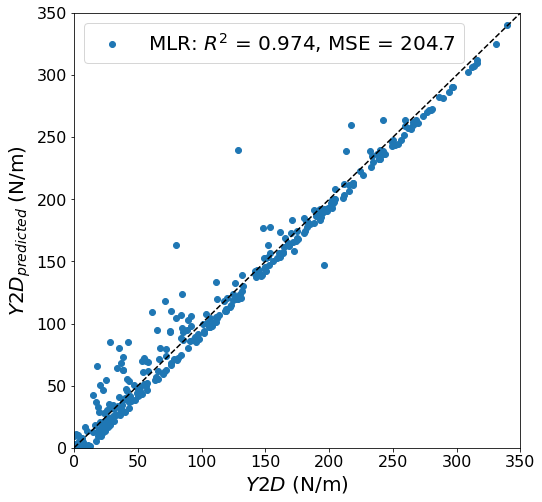

In [25]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mlr = linear_model.LinearRegression()
yhat_mlr = cross_val_predict(mlr, x, y, cv=kfold)
r2_mlr = r2_score(y, yhat_mlr)
mse_mlr = mean_squared_error(y, yhat_mlr)
label_mlr = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_mlr, mse_mlr)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
plt.ylabel(r"$Y2D_{predicted}$ (N/m)")
plt.xlabel(r"$Y2D$ (N/m)")
plt.legend()
plt.xlim([0, 350])
plt.ylim([0, 350])
plt.plot([0, 350], [0, 350], 'k--');
#f.savefig("Images_2DH_300K/Fit_5CV", dpi = 1200, transparent = False, facecolor = 'white')

_**Step-5:** Tunining the Hyperparamters_

A grid search with 5-fold cross validation has been performed to select the best parameters from the list of hyperparamters for MLR using the _GridSearchCV_ methed. 

In [26]:
from sklearn import model_selection
param_grid = {
    "fit_intercept": ["True", "False"],
    "positive": ["True", "False"],
}
model = model_selection.GridSearchCV(
      estimator=reg,
      param_grid=param_grid,
      scoring="r2",
      verbose=10,
      cv=5,
)

model.fit(x,y)


bestparams = model.best_estimator_.get_params()

bestscore = model.best_score_

print("Best paramters for the chosen model: %s " % bestparams)
print("Best r2 score: %.6f " % bestscore)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START fit_intercept=True, positive=True...........................
[CV 1/5; 1/4] END fit_intercept=True, positive=True;, score=0.986 total time=   0.0s
[CV 2/5; 1/4] START fit_intercept=True, positive=True...........................
[CV 2/5; 1/4] END fit_intercept=True, positive=True;, score=0.969 total time=   0.0s
[CV 3/5; 1/4] START fit_intercept=True, positive=True...........................
[CV 3/5; 1/4] END fit_intercept=True, positive=True;, score=0.920 total time=   0.0s
[CV 4/5; 1/4] START fit_intercept=True, positive=True...........................
[CV 4/5; 1/4] END fit_intercept=True, positive=True;, score=0.970 total time=   0.0s
[CV 5/5; 1/4] START fit_intercept=True, positive=True...........................
[CV 5/5; 1/4] END fit_intercept=True, positive=True;, score=0.751 total time=   0.0s
[CV 1/5; 2/4] START fit_intercept=True, positive=False..........................
[CV 1/5; 2/4] END fit_interce

This suggests that the model performs the best with the restriction that all coefficients be positive. Now we use the best parameters and redo the 5-fold cross validation. 

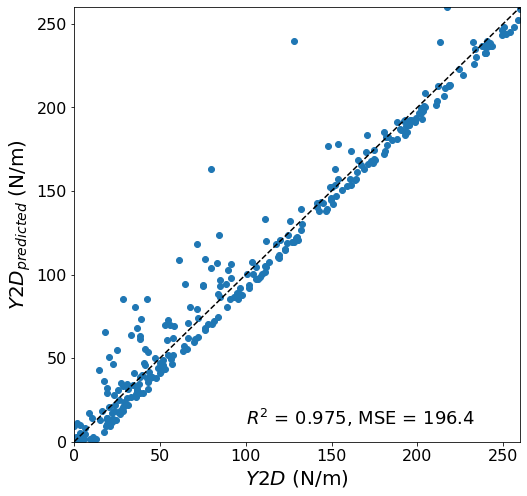

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

new_mlr = linear_model.LinearRegression(positive = True)
yhat_new_mlr = cross_val_predict(new_mlr, x, y, cv=kfold)
r2_new_mlr = r2_score(y, yhat_new_mlr)
mse_new_mlr = mean_squared_error(y, yhat_new_mlr)
#label_mlr = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_mlr, mse_mlr)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_new_mlr, 'o')
plt.ylabel(r"$Y2D_{predicted}$ (N/m)")
plt.xlabel(r"$Y2D$ (N/m)")

plt.xlim([0, 260])
plt.ylim([0, 260])
plt.plot([0, 260], [0, 260], 'k--');
plt.annotate(r"$R^2$ = %.3f, MSE = %.1f" % (r2_new_mlr, mse_new_mlr), (100, 10), fontsize=18);
#f.savefig("Images_2DH_300K/OptFit_5CV", dpi = 1200, transparent = False, facecolor = 'white')

